In [9]:
# import standard libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

import warnings
import pandas as pd

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import datetime
import pickle
from nltk.corpus import stopwords
import re
import regex
import string
from urllib.parse import urlparse

In [2]:
# import ML libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

In [3]:
# import evaluation libraries
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score

In [18]:
# load required models
sys.path.insert(0, '//wsl$/Ubuntu/home/zaidek/Part-II-Disertation/Neural Networks')
from models import FFNetworkBertEmbedding

In [19]:
# load required test datasets
from ipynb.fs.defs.datasets import BertProcessedTitleEmbeddingDataset

In [26]:
# import helper functions
from ipynb.fs.defs.eval_helper import evaluate_model, plot_classification_metrics, plot_losses, plot_losses_log

In [22]:
# import testing data
req_cols_without_url = ["title", "text", "time", "url", "descendants"]
cutoff = 20
batch_size = 1
with open("../../data/data_test", "rb") as fb:
    testing_data = pickle.load(fb)
testing_data_indexed = testing_data.reset_index(drop=True)
testing_scores = testing_data_indexed.score
testing_data_indexed = testing_data_indexed[req_cols_without_url]
testing_data_indexed.title = testing_data_indexed.title.fillna("")
testing_data_indexed.text = testing_data_indexed.text.fillna("")
testing_data_indexed.url = testing_data_indexed.url.fillna("")
testing_data_indexed.time = testing_data_indexed.time.fillna(0)
testing_data_indexed.descendants = testing_data_indexed.descendants.fillna(0)


dataset = BertProcessedTitleEmbeddingDataset(testing_data_indexed, testing_scores, cutoff)
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

In [23]:
# define loss function
loss_func = nn.BCEWithLogitsLoss()

In [25]:
# load models
bert_model = FFNetworkBertEmbedding(1, 768)
bert_model.load_state_dict(torch.load("../trained_models/bert_model_best_3.pth"))
bert_model.eval()

FFNetworkBertEmbedding(
  (hidden): Sequential(
    (0): Linear(in_features=768, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=900, bias=True)
    (5): ReLU()
    (6): Linear(in_features=900, out_features=800, bias=True)
    (7): ReLU()
    (8): Linear(in_features=800, out_features=700, bias=True)
    (9): ReLU()
    (10): Linear(in_features=700, out_features=600, bias=True)
    (11): ReLU()
    (12): Linear(in_features=600, out_features=300, bias=True)
    (13): ReLU()
    (14): Linear(in_features=300, out_features=128, bias=True)
    (15): ReLU()
    (16): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [27]:
eval_1 = evaluate_model(data_loader, bert_model, loss_func, "cpu")

In [28]:
t = eval_1[0][0]
print(t)
print(t.detach().squeeze(1))

tensor([[-2.3474]], grad_fn=<AddmmBackward0>)
tensor([-2.3474])


\\wsl$\Ubuntu\home\zaidek\Part-II-Disertation\Neural Networks\evaluation\eval_helper.ipynb:49: RuntimeWarning: divide by zero encountered in log
  "        # add data to outputs\n",


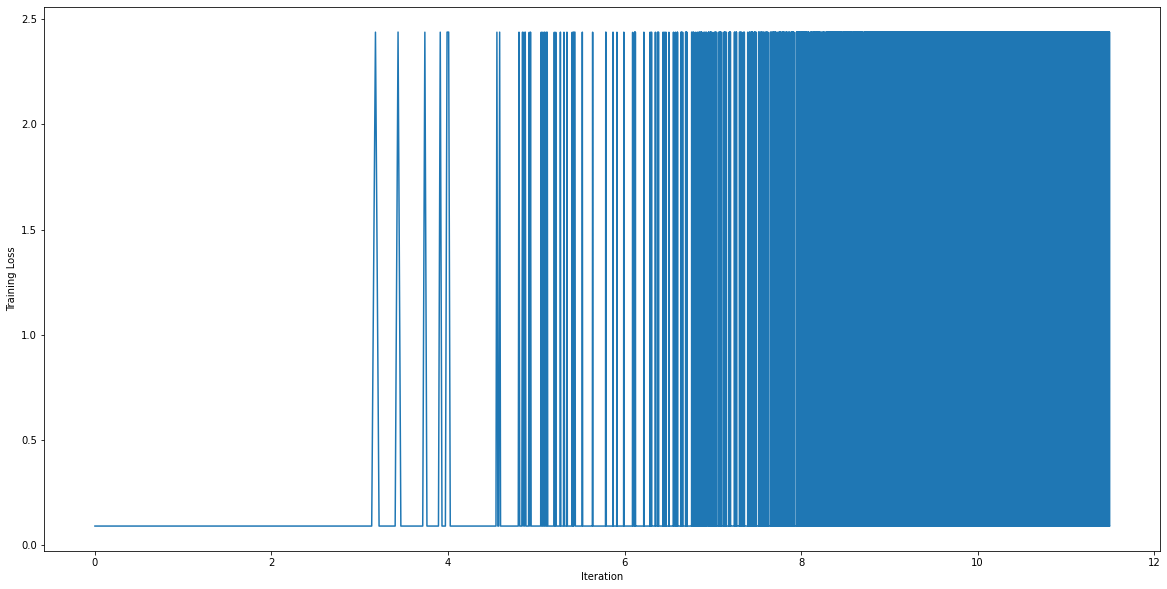

In [29]:
preds, labels, losses = eval_1
preds_2 = [0 if nn.Sigmoid()(pred.detach().squeeze(1)) < 0.5 else 1 for pred in preds]
labels_2 = [label.detach().item() for label in labels]
losses_2 = [loss.detach() for loss in losses]
plot_losses_log(losses_2, "Testing Loss")

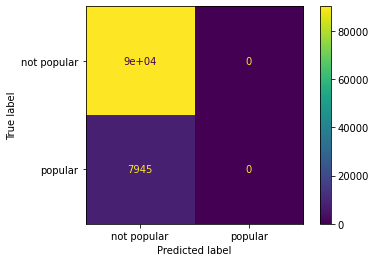

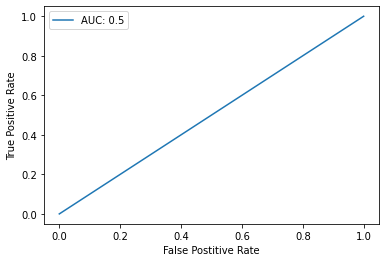

In [30]:
plot_classification_metrics(labels_2, preds_2)

In [17]:
with open("losses/LossWithComments", "rb") as fb:
    losses_with_comments = pickle.load(fb)

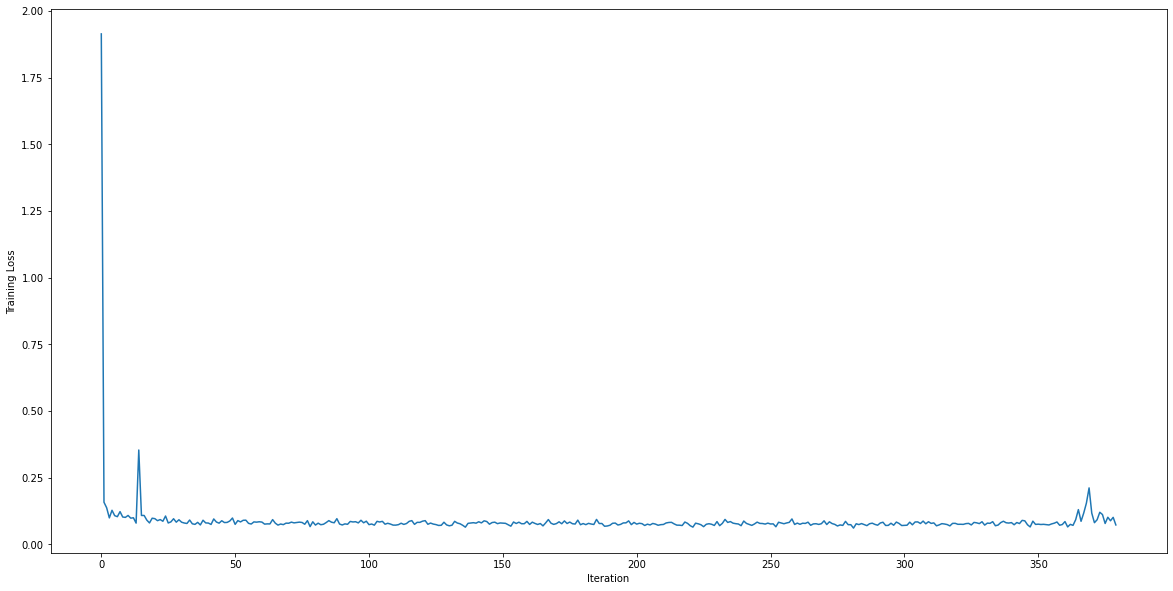

In [20]:
plot_losses(losses_with_comments, "Training Loss")